# Convolutions

> Convolutions and convolutional neural network

Adapted from:

- [https://youtu.be/0Hi2r4CaHvk?si=Adfv4DL1LfoNr0nC](https://youtu.be/0Hi2r4CaHvk?si=Adfv4DL1LfoNr0nC)

In [1]:
#| default_exp convs

In [2]:
# |export
import os
import tempfile
from contextlib import contextmanager
from typing import Mapping

import datasets
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as T
from datasets import load_dataset, load_from_disk
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, default_collate
from tqdm import tqdm

from slowai.datasets import show_image, show_images

In [3]:
dsd = load_dataset("mnist")
trn, tst = dsd["train"], dsd["test"]
xb = T.to_tensor(trn[0]["image"])[None, ...]
xb.shape

torch.Size([1, 1, 28, 28])

This is a [nice resource](https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c).

Convolutions encode **position equivariance** like the probability that there is a bird at any particular location in an image. It's implemented as a sliding matrix multiplication, followed by a sum like so:

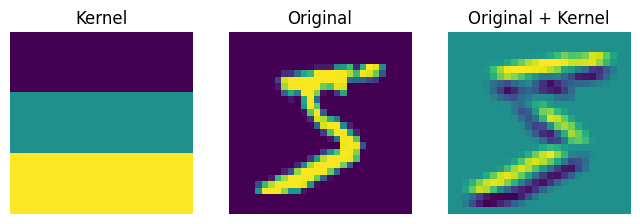

In [4]:
kernel = tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])


def apply_kernel(row, col, img, kernel):
    # Normally, you would need to check if the kernel has
    # an odd or even size
    width, height = kernel.shape
    receptive_field = img[
        row - (height // 2) : row + (height // 2) + 1,
        col - (width // 2) : col + (width // 2) + 1,
    ]
    return (receptive_field * kernel).sum()


*_, w, h = xb.shape
processed = [
    [apply_kernel(i, j, xb.squeeze(), kernel) for j in range(1, w - 1)]
    for i in range(1, h - 1)
]
processed = tensor(processed)

show_images(
    [kernel, xb.squeeze(), processed],
    titles=["Kernel", "Original", "Original + Kernel"],
    figsize=(8, 8),
);

You can see it is very easy to think of interesting features of images that are just convolutional filters.

One clever way of implementing this is the `im2col` algorithm that represents a convolution as a matrix multiplication and take advantage of highly efficient algorithms for matrix multiplications. It does so by unrolling the input matrix matrix such that every receptive field is a contiguous block of values, with a correspondingly unrolled contiguous block of convolutional filter values. The values of the convolutional matrix can change, but they are shared.

This has a corresponding function in PyTorch.

In [5]:
F.unfold?

Signature:
F.unfold(
    input: torch.Tensor,
    kernel_size: None,
    dilation: None = 1,
    padding: None = 0,
    stride: None = 1,
) -> torch.Tensor
Docstring:
Extracts sliding local blocks from a batched input tensor.

.. warning::
    Currently, only 4-D input tensors (batched image-like tensors) are
    supported.

.. warning::

    More than one element of the unfolded tensor may refer to a single
    memory location. As a result, in-place operations (especially ones that
    are vectorized) may result in incorrect behavior. If you need to write
    to the tensor, please clone it first.


See :class:`torch.nn.Unfold` for details
File:      ~/micromamba/envs/slowai/lib/python3.11/site-packages/torch/nn/functional.py
Type:      function

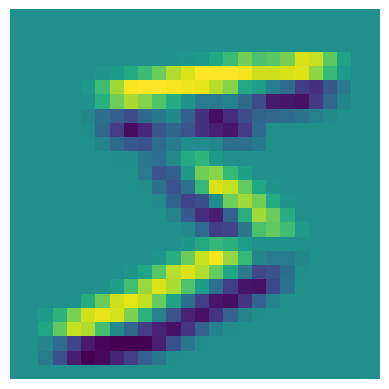

In [6]:
# Need to add a channel dimension and a batch dimension
xb_unfolded = F.unfold(xb, kernel_size=(3, 3)).float()
kernel_unfolded = kernel.view(-1).float()

# im2col
xb_processed = kernel_unfolded @ xb_unfolded

# Reshape
xb_processed = xb_processed.view(26, 26)
show_image(xb_processed);

This unfold trick is about the same efficiency as the built-in convolution layer. 

For better performance, we can apply a bunch of convolutions simultaneously.

In [7]:
diag1_edge = tensor([[0, -1, 1], [-1, 1, 0], [1, 0, 0]]).float()
diag2_edge = tensor([[1, -1, 0], [0, 1, -1], [0, 0, 1]]).float()
left_edge = tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([3, 3, 3])

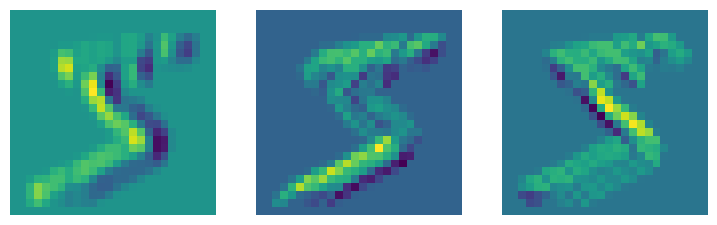

In [8]:
batch_features = F.conv2d(xb, edge_kernels[:, None, ...])
show_images([batch_features[0, i] for i in range(3)])

The parameters to a convolutional layer are the **stride** and **padding**, which allow us to manipulate the size of the feature map.

## Creating a CNN

For classifying digits, we cannot solely use convolutional layers because it gives 10 outputs _per pixel_!

In [9]:
nh, n_outputs = 30, 10

partial_model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 30, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(30, 10, kernel_size=3, padding=1),
)

partial_model(xb).shape

torch.Size([1, 10, 28, 28])

Instead, we'll add a lot of layers and chew up the extra feature map dimensions until we have a 1x1x10 feature map.

We'll add a convenience function to create conv layers with optional activations.

In [10]:
# |export
def conv(ni, nf, ks=3, stride=2, act=True):
    conv_ = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks // 2)
    if act:
        return nn.Sequential(conv_, nn.ReLU())
    else:
        return conv_

We also need some annoying `device` stuff.

In [11]:
# |export
def_device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)


def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    if isinstance(x, Mapping):
        return {k: v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in x)

Now, define the model...

Note here that the default stride is `2`, such that the feature map is downsampled by 2 each layer.

In [12]:
# |export
def get_model():
    model = nn.Sequential(
        conv(1, 4),  # 14x14
        conv(4, 8),  # 7x7
        conv(8, 16),  # 4x4
        conv(16, 16),  # 2x2
        conv(16, 10, act=False),  # 1x1
        nn.Flatten(),
    )
    return model.to(def_device)


get_model()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

And we can train! 🏋️

In [13]:
# |export
def accuracy(y, y_pred):
    n, _ = y.shape
    return (y.argmax(axis=1) == y_pred).sum() / n


def fit(epochs, model, loss_func, opt, train_dl, valid_dl, tqdm_=False):
    progress = tqdm if tqdm_ else lambda x: x
    for epoch in range(epochs):
        model.train()
        for batch in progress(train_dl):
            xb, yb = map(to_device, batch)
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.0, 0.0, 0
            for batch in progress(valid_dl):
                xb, yb = map(to_device, batch)
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item() * n
                tot_acc += accuracy(pred, yb).item() * n

        print(
            f"{epoch=}, validation loss={tot_loss / count:.3f}, validation accuracy={tot_acc / count:.2f}"
        )
    return tot_loss / count, tot_acc / count


@contextmanager
def get_dls_from_dataset_dict(dsd, collate_fn=default_collate, bs=32):
    datasets.logging.disable_progress_bar()
    with tempfile.TemporaryDirectory() as tdir:
        dls = []
        for split in ["train", "test"]:
            dir_ = os.path.join(tdir, split)
            dsd[split].save_to_disk(dir_)
            ds = load_from_disk(dir_).with_format("torch")
            dl = DataLoader(ds, batch_size=bs, collate_fn=collate_fn, num_workers=8)
            dls.append(dl)
        yield dls

In [14]:
# |export
def fashion_collate(examples):
    batch = default_collate(examples)
    xb = batch["image"][:, None, ...].float() / 255
    yb = batch["label"]
    return xb, yb


@contextmanager
def fashion_mnist(bs=256):
    dsd = load_dataset("fashion_mnist")
    with get_dls_from_dataset_dict(dsd, collate_fn=fashion_collate, bs=bs) as dls:
        yield dls

In [15]:
model = get_model()
with fashion_mnist() as dls:
    fit(6, model, F.cross_entropy, optim.SGD(model.parameters(), lr=0.1), *dls)

epoch=0, validation loss=1.041, validation accuracy=0.62
epoch=1, validation loss=0.767, validation accuracy=0.73
epoch=2, validation loss=0.623, validation accuracy=0.78
epoch=3, validation loss=0.561, validation accuracy=0.80
epoch=4, validation loss=0.515, validation accuracy=0.81
epoch=5, validation loss=0.483, validation accuracy=0.82


This gives us comparable accuracy to the linear model, which had 39,760 parameters. In contrast...

In [16]:
sum(p.numel() for p in model.parameters())

5274

More tips:

- Chewing up the feature map until we have one logit per dimension is not the only way to summarize the features before a classification/regression head. We can also use a dense layer or global average pooling
- The receptive field of a convolution grows through the network, as the convolutions are functions of convolutions. Really nice illustration of that [here](https://www.youtube.com/watch?v=0Hi2r4CaHvk&t=2769s)

In [17]:
#| hide
import nbdev

nbdev.nbdev_export()